https://www.kaggle.com/capiru/cassavanet-starter-easy-gpu-tpu-cv-0-9 노트북 참고

In [24]:
config_params = {
    'fold_num':5,
    'seed':42,
    'model_arch':'tf_efficientnet_b4_ns',
    'img_size':10,
    'train_bs':16,
    'valid_bs':16,
    'lr': 1e-4,
    'min_lr': 8e-7,
    'weight_decay' : 0,
    'num_workers':4,
#     'accum_iter': 2,
#     'verbose_step':1,
    'device':'cuda:0',
    'loss':'TaylorSmoothedLoss',
    'scheduler_name' : 'CosineAnnealingWarmRestarts',
    'optimizer':'AdamW',
    'fold_num':[0,2],
}
neptune.init(project_qualified_name = 'younghoon/cassava',
              api_token = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZjEwMWE3NDUtZDFhZS00MDYxLWFkNjktODgzN2RiNWEwNmY1In0=',
              )
#pass parameters to create experiment
neptune.create_experiment(params= config_params, name= 'CassavaNet', description = 'CassavaNet baseline code'
                          , tags=['CassavaNet','EfficientNet'], )

https://ui.neptune.ai/younghoon/cassava/e/CAS-21


Experiment(CAS-21)

In [25]:
# ====================================================
# Configurations
# ====================================================
import os
class CFG:
    DEBUG = False
    
    #Model Params
    device = 'GPU' #['CPU','GPU','TPU']
    N_FOLDS = 5
    MODEL_NAME = 'tf_efficientnet_b4_ns' # Recommended : ['deit_base_patch16_384','vit_large_patch16_384','tf_efficientnet_b4_ns','resnext50_32x4d']
    pretrained = True   
    N_CLASSES = 5
    #TRAIN_FOLDS = [0,1,2,3,4]
    TRAIN_FOLDS = [0,2] #Folds to be Trained
    
    scheduler_name = 'CosineAnnealingWarmRestarts'
    # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'OneCycleLR', 'GradualWarmupSchedulerV2']
    scheduler_update = 'epoch' #['batch','epoch']
    criterion_name = 'TaylorSmoothedLoss'
    # ['CrossEntropyLoss', LabelSmoothing', 'FocalLoss','FocalCosineLoss', 'SymmetricCrossEntropyLoss', 'BiTemperedLoss', 'TaylorCrossEntropyLoss', 'TaylorSmoothedLoss']
    optimizer_name = 'AdamW' #['Adam','AdamW','AdamP','Ranger'] -> AdamP doesn't work on TPUs
    LR_RAMPUP_EPOCHS = 1
    LR_SUSTAIN_EPOCHS = 0
    
    FREEZE = False #If you fine tune after START_FREEZE epochs
    START_FREEZE = 8
    
    #Image Size
    HEIGHT = 512 #If VIT or deit is chosen as model: need 384 x 384
    WIDTH = 512
    CHANNELS = 3
    TRAIN_AUG_TYPE = 'train' #['train','lightaug','heavyaug','autoaugment']
    VALID_AUG_TYPE = 'valid' #['valid']
    
    #Training Params
    BATCH_SIZE = 16 # PER REPLICA FOR TPUS
    #RECOMMENDED : effnet = 16 ; resnext = 8 ; vit = 4 ; deit = 4
    EPOCHS = 10 # more is definitely plausible and recommended around 10
    LR = 1e-4
    LR_START =1e-4
    LR_MIN = 8e-7
    weight_decay = 0
    eps = 1e-8
    PATIENCE = 4
    
    #BiTemperedLoss
    T1 = 0.2
    T2 = 1.1
    LABEL_SMOOTH = 0.20
    
    #CosineAnnealingWarmRestarts
    T_0 = 7
    
    #CosineAnnealingLR
    T_max = EPOCHS
    
    NUM_WORKERS = 4
    
    model_print = False #If the model architecture is printed
    tqdm = True #If training bar is shown
    
    IMG_MEAN = [0.485, 0.456, 0.406] #Mean for normalization Transform cassava = [0.4303, 0.4967, 0.3134] imgnet = [0.485, 0.456, 0.406]
    IMG_STD = [0.229, 0.224, 0.225] #STD for normalization Transform cassava = [0.2142, 0.2191, 0.1954] imgnet = [0.229, 0.224, 0.225]
    
    USE_2019 = True #Use 2019 images?
    
    #n_procs = number of replicas -> TPU
#     n_procs = 1 #You can set it to 1 and run a TPU as a GPU if you want
    BGR = False #Alternate method for loading images -> set to true is a bit slower 
    SEED = 42


In [26]:
# ====================================================
# Required Installations
# ====================================================
!pip install --quiet timm==0.3.2

if CFG.device == 'TPU':
    import os
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
    os.system('export XLA_USE_BF16=1')
    os.system('export XLA_TENSOR_ALLOCATOR_MAXSIZE=100000000')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    import ignite.distributed as idist
    #CFG.LR = CFG.LR * CFG.n_procs
    #CFG.BATCH_SIZE = CFG.BATCH_SIZE * CFG.n_procs
    
if CFG.optimizer_name == 'Ranger':
    !pip install --quiet '../input/pytorch-ranger'
elif CFG.optimizer_name == 'AdamP':
    !pip install adamp
    
if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
    !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [27]:
# ====================================================
# Library
# ====================================================
import random
import math
import time

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import cv2
from sklearn.model_selection import GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torchvision
from torchvision import models as tvmodels
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from tqdm import tqdm
import timm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,StratifiedKFold

import albumentations as A
from albumentations import Compose
from albumentations.pytorch import ToTensorV2


from PIL import Image, ImageOps, ImageEnhance, ImageChops


if CFG.optimizer_name == 'Ranger':
    from pytorch_ranger import Ranger
elif CFG.optimizer_name == 'AdamP':
    from adamp import AdamP
    
if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
    from warmup_scheduler import GradualWarmupScheduler


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Augmentations

In [28]:
# ====================================================
# Augmentations
# ====================================================
Aug_Norm = A.Normalize(mean=CFG.IMG_MEAN, std=CFG.IMG_STD, max_pixel_value=255.0, p=1.0)
Drop_Rand = A.CoarseDropout(max_holes=12, max_height=int(0.11*CFG.HEIGHT), max_width=int(0.11*CFG.WIDTH),
                            min_holes=1, min_height=int(0.03*CFG.HEIGHT), min_width=int(0.03*CFG.WIDTH),
                            always_apply=False, p=0.5)
Rand_Crop = A.RandomCrop(height= CFG.HEIGHT, width = CFG.WIDTH,always_apply=True, p=1.0)
Resize_Crop = A.RandomResizedCrop(CFG.HEIGHT, CFG.WIDTH,p=1.0)
train_transforms = Compose([
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            A.RandomBrightnessContrast(
                    brightness_limit=(-0.1,0.1), 
                    contrast_limit=(-0.1, 0.1), 
                    p=0.5
                ),
            Resize_Crop,
            Drop_Rand,           
            Aug_Norm,   
            ToTensorV2(p=1.0),
        ], p=1.)

light_transforms = Compose([
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
            Resize_Crop,
            Aug_Norm,   
            ToTensorV2(p=1.0),
        ], p=1.)

heavy_transforms = Compose([
    A.HorizontalFlip(p=0.5),
    
    A.Resize(CFG.HEIGHT, CFG.WIDTH),
    
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.augmentations.transforms.ColorJitter(brightness=0.10, contrast=0.2, saturation=0.2, hue=0.00, always_apply=False, p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.augmentations.transforms.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5),
    A.augmentations.transforms.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
    
    A.augmentations.transforms.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Aug_Norm,
    ToTensorV2(p=1.0),])

valid_transforms = Compose([
            A.CenterCrop(CFG.HEIGHT, CFG.WIDTH),
            Aug_Norm,   
            ToTensorV2(p=1.0),
        ], p=1.)

test_aug = Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p = 1.0),
            #A.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.00, always_apply=False, p=1.0),
            Rand_Crop,
            Aug_Norm,
            ToTensorV2(p=1.0)
        ], p=1.)

image_net_post = Compose([
            Resize_Crop,
            Drop_Rand,
            Aug_Norm,    
            ToTensorV2(p=1.0)
        ], p=1.)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [29]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1 = CFG.T1,
        t2 = CFG.T2,
        label_smoothing=CFG.LABEL_SMOOTH,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

class BiTemperedLogistic(nn.Module):
    def __init__(self, T1 = CFG.T1, T2 = CFG.T2, LABEL_SMOOTH = CFG.LABEL_SMOOTH):
        super().__init__()
        self.T1 = T1
        self.T2 = T2
        self.LABEL_SMOOTH = LABEL_SMOOTH

    def forward(self, logits,labels):
        return bi_tempered_logistic_loss(logits, labels,t1 = self.T1,t2 = self.T2, label_smoothing = self.LABEL_SMOOTH)
    
class SymmetricCrossEntropy(nn.Module):

    def __init__(self, alpha=0.1, beta=1.0, num_classes= 5):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes

    def forward(self, logits, targets, reduction='mean'):
        onehot_targets = torch.eye(self.num_classes)[targets].cuda()
        ce_loss = F.cross_entropy(logits, targets, reduction=reduction)
        rce_loss = (-onehot_targets*logits.softmax(1).clamp(1e-7, 1.0).log()).sum(1)
        if reduction == 'mean':
            rce_loss = rce_loss.mean()
        elif reduction == 'sum':
            rce_loss = rce_loss.sum()
        return self.alpha * ce_loss + self.beta * rce_loss
    
class LabelSmoothingLoss(nn.Module): 
    def __init__(self, classes=5, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        if CFG.criterion_name == 'LabelSmoothingLoss':
            pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad():
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class FocalCosineLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, xent=.1):
        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

        self.xent = xent

        self.y = torch.Tensor([1]).cuda()

    def forward(self, input, target, reduction="mean"):
        cosine_loss = F.cosine_embedding_loss(input, F.one_hot(target, num_classes=input.size(-1)), self.y, reduction=reduction)

        cent_loss = F.cross_entropy(F.normalize(input), target, reduce=False)
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * cent_loss

        if reduction == "mean":
            focal_loss = torch.mean(focal_loss)

        return cosine_loss + self.xent * focal_loss
    
class TaylorSoftmax(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        '''
        usage similar to nn.Softmax:
            >>> mod = TaylorSoftmax(dim=1, n=4)
            >>> inten = torch.randn(1, 32, 64, 64)
            >>> out = mod(inten)
        '''
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out
    
class TaylorCrossEntropyLoss(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, n=2, ignore_index=-1, reduction='mean'):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, logits, labels):
        '''
        usage similar to nn.CrossEntropyLoss:
            >>> crit = TaylorCrossEntropyLoss(n=4)
            >>> inten = torch.randn(1, 10, 64, 64)
            >>> label = torch.randint(0, 10, (1, 64, 64))
            >>> out = crit(inten, label)
        '''
        log_probs = self.taylor_softmax(logits).log()
        loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
                ignore_index=self.ignore_index)
        return loss
    
class TaylorSmoothedLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.2):
        super(TaylorSmoothedLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(CFG.N_CLASSES, smoothing=CFG.LABEL_SMOOTH)

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

### Utils

In [30]:
# ====================================================
# Utils
# ====================================================
def retrieve_df(df,name,idx):
    series = df[name].iloc[idx]
    series.reset_index(drop=True,inplace=True)
    return series

def accuracy_metric(input, targs):
    return accuracy_score(targs.cpu(), input.cpu())

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
    class GradualWarmupSchedulerV2(GradualWarmupScheduler):
        def __init__(self, optimizer = None, multiplier = CFG.LR/CFG.LR_START, total_epoch = CFG.LR_RAMPUP_EPOCHS, after_scheduler=None):
            super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
            self.after_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = CFG.T_0 - CFG.LR_RAMPUP_EPOCHS, T_mult=1, eta_min=CFG.LR_MIN, last_epoch=-1)
        def get_lr(self):
            if self.last_epoch > self.total_epoch:
                if self.after_scheduler:
                    if not self.finished:
                        self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                        self.finished = True
                    return self.after_scheduler.get_lr()
                return [base_lr * self.multiplier for base_lr in self.base_lrs]
            if self.multiplier == 1.0:
                return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
            else:
                return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

#Choose Criterions for the Training Loop
if CFG.criterion_name == 'BiTemperedLoss':
    CFG.criterion = BiTemperedLogistic()
    CFG.val_criterion = BiTemperedLogistic()
elif CFG.criterion_name == 'SymmetricCrossEntropyLoss':
    CFG.criterion = SymmetricCrossEntropy()
    CFG.val_criterion = SymmetricCrossEntropy()
elif CFG.criterion_name == 'CrossEntropyLoss':
    CFG.criterion = nn.CrossEntropyLoss()
    CFG.val_criterion = nn.CrossEntropyLoss()
elif CFG.criterion_name == 'LabelSmoothingLoss':
    CFG.criterion = LabelSmoothingLoss()
    CFG.val_criterion = LabelSmoothingLoss()
elif CFG.criterion_name == 'FocalLoss':
    CFG.criterion = FocalLoss()
    CFG.val_criterion = FocalLoss()
elif CFG.criterion_name == 'FocalCosineLoss':
    CFG.criterion = FocalCosineLoss()
    CFG.val_criterion = FocalCosineLoss()
elif CFG.criterion_name == 'TaylorCrossEntropyLoss':
    CFG.criterion = TaylorCrossEntropyLoss()
    CFG.val_criterion = TaylorCrossEntropyLoss()
elif CFG.criterion_name == 'TaylorSmoothedLoss':
    CFG.criterion = TaylorSmoothedLoss()
    CFG.val_criterion = TaylorSmoothedLoss()
    
    
def GetScheduler(scheduler_name,optimizer,batches):
    #['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'OneCycleLR', 'GradualWarmupSchedulerV2']
    if scheduler_name == 'OneCycleLR':
        return torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr = 1e-2,epochs = CFG.EPOCHS,steps_per_epoch = batches+1,pct_start = 0.1)
    elif scheduler_name == 'CosineAnnealingWarmRestarts':
        return torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = CFG.T_0, T_mult=1, eta_min=CFG.LR_MIN, last_epoch=-1)
    elif scheduler_name == 'CosineAnnealingLR':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = CFG.T_max, eta_min=0, last_epoch=-1)
    elif scheduler_name == 'ReduceLROnPlateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=1, threshold=0.0001, cooldown=0, min_lr=CFG.LR_MIN, eps=CFG.eps)
    elif scheduler_name == 'GradualWarmupSchedulerV2':
        return GradualWarmupSchedulerV2(optimizer=optimizer)
    
def GetOptimizer(optimizer_name,parameters):
    #['Adam','Ranger']
    if optimizer_name == 'Adam':
        if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
            return torch.optim.Adam(parameters, lr=CFG.LR_START, weight_decay=CFG.weight_decay, amsgrad=False)
        else:
            return torch.optim.Adam(parameters, lr=CFG.LR, weight_decay=CFG.weight_decay, amsgrad=False)
    elif optimizer_name == 'AdamW':
        if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
            return torch.optim.AdamW(parameters, lr=CFG.LR_START, weight_decay=CFG.weight_decay, amsgrad=False)
        else:
            return torch.optim.Adam(parameters, lr=CFG.LR, weight_decay=CFG.weight_decay, amsgrad=False)
    elif optimizer_name == 'AdamP':
        if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
            return AdamP(parameters, lr=CFG.LR_START, weight_decay=CFG.weight_decay)
        else:
            return AdamP(parameters, lr=CFG.LR, weight_decay=CFG.weight_decay)
    elif optimizer_name == 'Ranger':
        return Ranger(parameters,lr = CFG.LR,alpha = 0.5, k = 6,N_sma_threshhold = 5,betas = (0.95,0.999),eps=CFG.eps,weight_decay=CFG.weight_decay)

def print_scheduler(scheduler = None,scheduler_update = CFG.scheduler_update,optimizer = None, batches = -1, epochs = -1, model = None):
    lrs = []
    if scheduler_update == 'epoch':
        for epoch in range(epochs):
            scheduler.step(epoch)
            lrs.append(optimizer.param_groups[0]["lr"])
        plt.figure(figsize=(15,4))
        plt.plot(lrs)
    elif scheduler_update == 'batch':
        for epoch in range(epochs):
            for batch in range(batches):
                scheduler.step()
                lrs.append(optimizer.param_groups[0]["lr"])
        plt.figure(figsize=(15,4))
        plt.plot(lrs)
    
SEED = CFG.SEED
seed_everything(SEED)  
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Datasets

In [31]:
# Datasets
# ====================================================
class GetData(Dataset):
    def __init__(self, Dir, FNames, labels,Type):
        self.dir = Dir
        self.fnames = FNames
        self.lbs = labels
        self.type = Type
        self.auto_augment = timm.data.auto_augment.auto_augment_transform('originalr',None)
        
    def __len__(self):
        return len(self.fnames)
    
    def get_x(self,index):
        if CFG.BGR:
            x = cv2.imread(os.path.join(self.dir, self.fnames[index]))
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        else:
            x = imread(os.path.join(self.dir, self.fnames[index]))
        return x

    def __getitem__(self, index):
        if "train" in self.type:
            x = self.get_x(index)
            aug_data = train_transforms(image = x)
            return aug_data['image'], self.lbs[index]
        elif "lightaug" in self.type:
            x = self.get_x(index)
            aug_data = light_transforms(image = x)
            return aug_data['image'], self.lbs[index]
        elif "heavyaug" in self.type:
            x = self.get_x(index)
            aug_data = heavy_transforms(image = x)
            return aug_data['image'], self.lbs[index]
        elif "autoaugment" in self.type:
            x = Image.open(os.path.join(self.dir, self.fnames[index]))
            aug_image = self.auto_augment(x)
            aug_data = image_net_post(image = np.asarray(aug_image,dtype = np.float32))
            return aug_data['image'], self.lbs[index]
        elif "valid" in self.type:
            x = self.get_x(index)
            aug_data = valid_transforms(image = x)
            return aug_data['image'], self.lbs[index]
        elif "tr-tst" in self.type:
            x = self.get_x(index)
            return x, self.lbs[index]
        elif "test" in self.type:
            x = self.get_x(index)
            return x, self.fnames[index]

## CV split

In [32]:
# ====================================================
# CV Split
# ====================================================
DATA_PATH = './input/'
TRAIN_DIR = DATA_PATH + 'train_images/'

DATA_PATH_2019 = './input/cassava-leaf-disease-merged/'
TRAIN_DIR_2019 = DATA_PATH_2019 + 'train/'
TEST_DIR = DATA_PATH + 'test_images/'

#This guarantees that no images from 2019 contaminate the validation split
if CFG.USE_2019:
    train_df_merged = pd.read_csv(DATA_PATH_2019 + 'merged.csv')
    train_df = train_df_merged.loc[train_df_merged.source == 2020]
    if CFG.DEBUG:
        train_df = train_df.sample(500).reset_index(drop=True)
    train_df_2019 = train_df_merged.loc[train_df_merged.source == 2019]
    skf = StratifiedKFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=CFG.SEED)
    skf.get_n_splits(np.arange(train_df.shape[0]), train_df['label'])
    folds = [(idxT,idxV) for i,(idxT,idxV) in enumerate(skf.split(np.arange(train_df.shape[0]), train_df['label']))]
    if not CFG.DEBUG:
        folds_2019 = [np.concatenate((idxT,idxV)) for i,(idxT,idxV) in enumerate(skf.split(np.arange(train_df_2019.shape[0]), train_df_2019['label']))]
        for i in range(CFG.N_FOLDS):
            (idxT,idxV) = folds[i]
            folds[i] = (np.concatenate((idxT,train_df_2019.iloc[folds_2019[i]].index)),idxV)
            (idxT,idxV) = folds[i]
            print(np.bincount(train_df_merged['label'].iloc[idxT]),np.bincount(train_df['label'].iloc[idxV]))
    DATA_FOLD = TRAIN_DIR_2019
    del train_df_2019
else:
    train_df = pd.read_csv(DATA_PATH + 'train.csv')
    if CFG.DEBUG:
        train_df = train_df.sample(500).reset_index(drop=True)
    skf = StratifiedKFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=CFG.SEED)
    skf.get_n_splits(np.arange(train_df.shape[0]), train_df['label'])
    folds = [(idxT,idxV) for i,(idxT,idxV) in enumerate(skf.split(np.arange(train_df.shape[0]), train_df['label']))]
    for i in range(CFG.N_FOLDS):
        (idxT,idxV) = folds[i]
        print(np.bincount(train_df['label'].iloc[idxT]),np.bincount(train_df['label'].iloc[idxV]))
    
    train_df_merged = train_df
    DATA_FOLD = TRAIN_DIR

[ 1274  3038  2540 12831  2374] [ 218  438  477 2631  516]
[ 1274  3038  2540 12831  2374] [ 218  438  477 2631  516]
[ 1275  3038  2540 12830  2375] [ 217  438  477 2632  515]
[ 1275  3038  2540 12830  2375] [ 217  438  477 2632  515]
[ 1275  3039  2539 12830  2375] [ 217  437  478 2632  515]


## Augmentation visualization

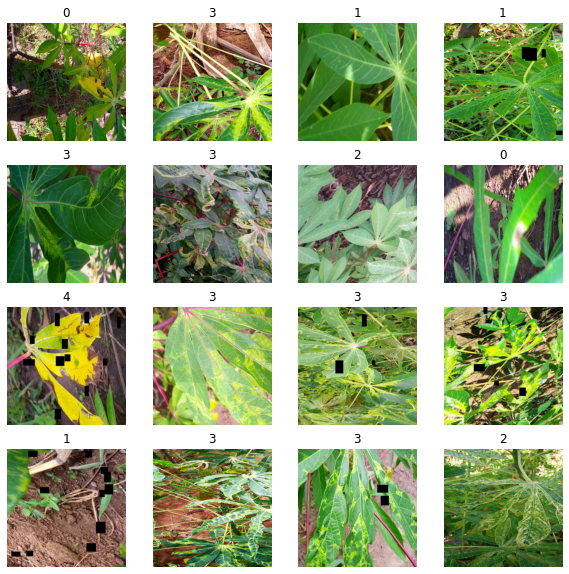

In [33]:
idx = [i for i in range(16)]
x_train = retrieve_df(train_df_merged,'image_id',idx)
y_train = retrieve_df(train_df_merged,'label',idx)
train_set = GetData(DATA_FOLD, x_train, y_train, Type = CFG.TRAIN_AUG_TYPE)
plt.figure(figsize=(10, 10))
inv_normalize = UnNormalize(mean = CFG.IMG_MEAN,std = CFG.IMG_STD)
for i,(image,label) in enumerate(train_set):
    ax = plt.subplot(4, 4, i + 1)
    aug_image = inv_normalize(image)
    aug_image = np.transpose(aug_image.numpy(),[1,2,0])
    plt.imshow(aug_image)
    label = train_df['label'].iloc[i]
    plt.title(label)
    plt.axis("off")
    if i == 15:
        break
del aug_image,label,image,ax

## Model

In [34]:
# Model
# ====================================================
class CassavaNet(nn.Module):
    def __init__(self, model_name=CFG.MODEL_NAME, pretrained=CFG.pretrained):
        super().__init__()
        self.model_name = model_name
        if model_name == 'deit_base_patch16_224' or model_name == 'deit_base_patch16_384':
            self.model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=pretrained)
        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)
        if 'efficientnet' in model_name:
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(self.n_features, CFG.N_CLASSES)
        elif model_name == 'vit_large_patch16_384' or model_name == 'deit_base_patch16_224' or model_name == 'deit_base_patch16_384':
            self.n_features = self.model.head.in_features
            self.model.head = nn.Linear(self.n_features, CFG.N_CLASSES)
        elif 'resnext' in model_name:
            self.n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(self.n_features, CFG.N_CLASSES)
        
    def forward(self, x):
        return self.model(x)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False
            
        if 'efficientnet' in self.model_name:
            for param in self.model.classifier.parameters():
                param.requires_grad = True
        elif self.model_name == 'vit_large_patch16_384' or 'deit_base_patch16_224':
            for param in self.model.head.parameters():
                param.requires_grad = True
        elif 'resnext' in self.model_name:
            for param in self.model.fc.parameters():
                param.requires_grad = True
            
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
            
model = CassavaNet()
if CFG.model_print:
    print(model)

### Train Loop

In [35]:
def train_one_epoch(model,optimizer,scheduler,scaler,train_loader,criterion,batches,epoch,DEVICE):   
    tr_loss = 0.0
    scores = 0.0
    trn_epoch_result = dict()
    model.train()
    if CFG.tqdm:
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=len(train_loader))
    else:
        progress = enumerate(train_loader)
    for i, (images,labels) in progress:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        if CFG.device == 'TPU':
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            xm.optimizer_step(optimizer)
        else:
            with autocast():
                logits = model(images)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        preds = F.softmax(logits).argmax(axis = 1)
        scores += (preds==labels).sum().cpu().numpy()

        
        if CFG.scheduler_update == 'batch':
            if not CFG.scheduler_name == 'OneCycleLR':
                scheduler.step(epoch + i/len(train_loader))
            else:
                scheduler.step()

        tr_loss += loss.detach().item()
        
        if CFG.tqdm:
            trn_epoch_result['Epoch'] = epoch
            trn_epoch_result['train_loss'] = round(tr_loss/(i+1), 4)
            trn_epoch_result['train_acc'] = round(scores/(i+1)/CFG.BATCH_SIZE, 4)
            trn_epoch_result['LR'] = round(optimizer.param_groups[0]["lr"],7)
            neptune.log_metric('loss_tr',round(tr_loss/(i+1), 4))

            progress.set_description(str(trn_epoch_result))
        else:
            print(tr_loss/(i+1))
    if CFG.scheduler_update == 'epoch':
            scheduler.step(epoch+1)
        
def val_one_epoch(model,DEVICE,loader,val_criterion,epoch,get_output = False):
    val_loss = 0.0
    scores = 0.0
    model.eval()
    val_progress = tqdm(enumerate(loader), desc="Loss: ", total=len(loader))
    with torch.no_grad():
        for i, (images,labels) in val_progress:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(images)
            val_loss_value = val_criterion(logits,labels)
            val_loss += val_loss_value.detach().item()

            preds = F.softmax(logits).argmax(axis = 1)
            scores += (preds==labels).sum().cpu().numpy()

            val_epoch_result = dict()
            val_epoch_result['Epoch'] = epoch
            val_epoch_result['val_loss'] = round(val_loss/(i+1), 4)

            val_epoch_result['val_acc'] = round(scores/(i+1)/CFG.BATCH_SIZE, 4)
            val_progress.set_description(str(val_epoch_result))
            neptune.log_metric('loss_fn', round(val_loss/(i+1), 4))
            
    if get_output:
        return val_loss/len(loader),scores/len(loader)/CFG.BATCH_SIZE
        
def model_train():
    if CFG.device == 'TPU':
        DEVICE = xm.xla_device()
    else:
        DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    for fold,(idxT, idxV) in enumerate(folds):
        if fold not in CFG.TRAIN_FOLDS:
            continue
        #if xm.is_master_ordinal():
        #    xm.master_print(fold)
        #______INSTANTIATE TRAINING DATASETS_____
        x_train = retrieve_df(train_df_merged,'image_id',idxT)
        y_train = retrieve_df(train_df_merged,'label',idxT)
        x_val = retrieve_df(train_df_merged,'image_id',idxV)
        y_val = retrieve_df(train_df_merged,'label',idxV)
        train_set = GetData(DATA_FOLD, x_train, y_train, Type = CFG.TRAIN_AUG_TYPE)
        val_set = GetData(DATA_FOLD, x_val, y_val, Type = CFG.VALID_AUG_TYPE)
        if CFG.device == 'TPU':
            train_sampler = torch.utils.data.distributed.DistributedSampler(
                train_set,
                num_replicas=xm.xrt_world_size(),
                rank=xm.get_ordinal(),
                shuffle=True)
            train_loader = DataLoader(train_set, batch_size=CFG.BATCH_SIZE, sampler=train_sampler,drop_last=True, num_workers=CFG.NUM_WORKERS)
        
            val_sampler = torch.utils.data.distributed.DistributedSampler(
                val_set,
                num_replicas=xm.xrt_world_size(),
                rank=xm.get_ordinal(),
                shuffle=False)
            val_loader = DataLoader(val_set, batch_size=CFG.BATCH_SIZE, sampler=val_sampler,drop_last=True, num_workers=CFG.NUM_WORKERS)
            scaler = None
        else:
            train_loader = DataLoader(train_set, batch_size=CFG.BATCH_SIZE, shuffle=True,drop_last=True, num_workers=CFG.NUM_WORKERS,pin_memory = True)
            val_loader = DataLoader(val_set, batch_size=CFG.BATCH_SIZE, shuffle=False,drop_last=True, num_workers=CFG.NUM_WORKERS,pin_memory = True)
            scaler = GradScaler()
            
        batches = len(train_loader)
        val_batches = len(val_loader)

        #INSTANTIATE FOLD MODEL
        if CFG.model is None:
            if CFG.device == 'TPU':
                if xm.is_master_ordinal(local=True):
                    CFG.model = CassavaNet(model_name=CFG.MODEL_NAME, pretrained=True)
                xm.rendezvous('ModelDone')
            else:
                CFG.model = CassavaNet(model_name=CFG.MODEL_NAME, pretrained=True)
        model = CFG.model.to(DEVICE)

        criterion = CFG.criterion.to(DEVICE)
        val_criterion = CFG.val_criterion.to(DEVICE)

        optimizer = GetOptimizer(CFG.optimizer_name, model.parameters())
        scheduler = GetScheduler(CFG.scheduler_name, optimizer,batches)
        
        saved_model = None
        best_val_acc = 0.0
        best_val_loss = 1e3
        fold_patience = 0.0
        for epoch in range(CFG.EPOCHS):
            if epoch >= CFG.START_FREEZE and CFG.FREEZE:
                print('Model Frozen -> Train Classifier Only')
                info = torch.load(saved_model,map_location = torch.device(DEVICE))
                model.load_state_dict(info)
                model.freeze()
                
                CFG.FREEZE = False
            #______TRAINING______
            if CFG.device == 'TPU':
                para_train_loader = pl.ParallelLoader(train_loader, [DEVICE])
                train_one_epoch(model,optimizer,scheduler,scaler,para_train_loader.per_device_loader(DEVICE),criterion,batches,epoch,DEVICE)
                del para_train_loader
                gc.collect()
            else:
                train_one_epoch(model,optimizer,scheduler,scaler,train_loader,criterion,batches,epoch,DEVICE)
            
            #______VALIDATION_______
            if CFG.device == 'TPU':
                para_val_loader = pl.ParallelLoader(val_loader, [DEVICE])
                val_loss, val_acc = val_one_epoch(model,DEVICE,para_val_loader.per_device_loader(DEVICE),val_criterion,epoch,get_output = True)
                del para_val_loader
                gc.collect()
                val_loss = np.sum(idist.all_gather(torch.tensor(val_loss)).to('cpu').numpy())/CFG.n_procs
                val_acc = np.sum(idist.all_gather(torch.tensor(val_acc)).to('cpu').numpy())/CFG.n_procs
                xm.master_print(f'Fold Ended at {round(val_acc, 4)} val accuracy')
            else:
                val_loss, val_acc = val_one_epoch(model,DEVICE,val_loader,val_criterion,epoch,get_output = True)
            
            if val_acc > best_val_acc:
                fold_patience = 0
                best_val_loss = val_loss/val_batches
                best_val_acc = val_acc
                if CFG.device == 'TPU':
                    xm.save(CFG.model.state_dict(),
                                f'{CFG.MODEL_NAME}_f{fold}_TPU_b{round(best_val_acc, 4)}.pth')
                    if saved_model is not None:
                        try:
                            os.remove("./"+saved_model)
                        except:
                            a = 1
                    xm.master_print(f'Model Saved at {round(best_val_acc, 5)} accuracy')
                    saved_model = f'{CFG.MODEL_NAME}_f{fold}_TPU_b{round(best_val_acc, 4)}.pth'
                else:
                    torch.save(model.state_dict(),
                            f'{CFG.MODEL_NAME}_f{fold}_b{round(best_val_acc, 4)}.pth')
                    
                    if saved_model is not None:
                        try:
                            os.remove("./"+saved_model)
                        except:
                            a = 1
                    saved_model = f'{CFG.MODEL_NAME}_f{fold}_b{round(best_val_acc, 4)}.pth'
                    neptune.log_metric('metric',best_val_acc)
                
                    print(f'Model Saved at {round(best_val_acc, 5)} accuracy')
            else:
                fold_patience += 1
                if fold_patience >= CFG.PATIENCE:
                    print(f'Early stopping due to model not improving for {CFG.PATIENCE} epochs')
                    CFG.model = None
                    break
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        CFG.model = None
                
def _map_fn(index,flags):
    torch.set_default_tensor_type('torch.FloatTensor')
    a = model_train()

In [36]:
import gc
gc.collect()

32772

In [37]:
CFG.model = CassavaNet(model_name=CFG.MODEL_NAME, pretrained=True)
if CFG.device == 'TPU':
    FLAGS = {}
    xmp.spawn(_map_fn, args=(FLAGS,), nprocs=CFG.n_procs, start_method='fork')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    a = model_train()

{'Epoch': 0, 'train_loss': 1.0426, 'train_acc': 0.8139, 'LR': 0.0001}: 100%|██████████| 1378/1378 [07:07<00:00,  3.23it/s]
{'Epoch': 0, 'val_loss': 0.9531, 'val_acc': 0.8785}: 100%|██████████| 267/267 [00:24<00:00, 11.11it/s]


Model Saved at 0.87851 accuracy


{'Epoch': 1, 'train_loss': 0.9803, 'train_acc': 0.858, 'LR': 9.51e-05}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s] 
{'Epoch': 1, 'val_loss': 0.9383, 'val_acc': 0.8926}: 100%|██████████| 267/267 [00:23<00:00, 11.23it/s]


Model Saved at 0.89256 accuracy


{'Epoch': 2, 'train_loss': 0.9589, 'train_acc': 0.8745, 'LR': 8.13e-05}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s]
{'Epoch': 2, 'val_loss': 0.9409, 'val_acc': 0.89}: 100%|██████████| 267/267 [00:23<00:00, 11.24it/s]  
{'Epoch': 3, 'train_loss': 0.9429, 'train_acc': 0.8849, 'LR': 6.14e-05}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s]
{'Epoch': 3, 'val_loss': 0.9355, 'val_acc': 0.8914}: 100%|██████████| 267/267 [00:23<00:00, 11.21it/s]
{'Epoch': 4, 'train_loss': 0.9339, 'train_acc': 0.8925, 'LR': 3.94e-05}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s]
{'Epoch': 4, 'val_loss': 0.9327, 'val_acc': 0.8926}: 100%|██████████| 267/267 [00:23<00:00, 11.24it/s]
{'Epoch': 5, 'train_loss': 0.9232, 'train_acc': 0.898, 'LR': 1.95e-05}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s] 
{'Epoch': 5, 'val_loss': 0.9262, 'val_acc': 0.8979}: 100%|██████████| 267/267 [00:23<00:00, 11.22it/s]


Model Saved at 0.89794 accuracy


{'Epoch': 6, 'train_loss': 0.9156, 'train_acc': 0.9028, 'LR': 5.7e-06}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s]
{'Epoch': 6, 'val_loss': 0.928, 'val_acc': 0.8947}: 100%|██████████| 267/267 [00:23<00:00, 11.28it/s] 
{'Epoch': 7, 'train_loss': 0.9401, 'train_acc': 0.8882, 'LR': 0.0001}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s]
{'Epoch': 7, 'val_loss': 0.9432, 'val_acc': 0.8872}: 100%|██████████| 267/267 [00:23<00:00, 11.27it/s]
{'Epoch': 8, 'train_loss': 0.9335, 'train_acc': 0.8929, 'LR': 9.51e-05}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s]
{'Epoch': 8, 'val_loss': 0.9456, 'val_acc': 0.8846}: 100%|██████████| 267/267 [00:23<00:00, 11.22it/s]
{'Epoch': 9, 'train_loss': 0.9227, 'train_acc': 0.8996, 'LR': 8.13e-05}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s]
{'Epoch': 9, 'val_loss': 0.9359, 'val_acc': 0.8909}: 100%|██████████| 267/267 [00:23<00:00, 11.25it/s]


Early stopping due to model not improving for 4 epochs


{'Epoch': 0, 'train_loss': 1.0399, 'train_acc': 0.8168, 'LR': 0.0001}: 100%|██████████| 1378/1378 [07:08<00:00,  3.22it/s]
{'Epoch': 0, 'val_loss': 0.9552, 'val_acc': 0.879}: 100%|██████████| 267/267 [00:23<00:00, 11.26it/s] 


Model Saved at 0.87898 accuracy


{'Epoch': 1, 'train_loss': 0.9776, 'train_acc': 0.8623, 'LR': 9.51e-05}: 100%|██████████| 1378/1378 [07:07<00:00,  3.22it/s]
{'Epoch': 1, 'val_loss': 0.9349, 'val_acc': 0.8961}: 100%|██████████| 267/267 [00:23<00:00, 11.24it/s]


Model Saved at 0.89607 accuracy


{'Epoch': 2, 'train_loss': 0.9615, 'train_acc': 0.8705, 'LR': 8.13e-05}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s]
{'Epoch': 2, 'val_loss': 0.9397, 'val_acc': 0.889}: 100%|██████████| 267/267 [00:23<00:00, 11.25it/s] 
{'Epoch': 3, 'train_loss': 0.9455, 'train_acc': 0.8837, 'LR': 6.14e-05}: 100%|██████████| 1378/1378 [07:07<00:00,  3.22it/s]
{'Epoch': 3, 'val_loss': 0.9327, 'val_acc': 0.8926}: 100%|██████████| 267/267 [00:23<00:00, 11.24it/s]
{'Epoch': 4, 'train_loss': 0.9353, 'train_acc': 0.8914, 'LR': 3.94e-05}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s]
{'Epoch': 4, 'val_loss': 0.93, 'val_acc': 0.8916}: 100%|██████████| 267/267 [00:23<00:00, 11.26it/s]  
{'Epoch': 5, 'train_loss': 0.9241, 'train_acc': 0.8989, 'LR': 1.95e-05}: 100%|██████████| 1378/1378 [07:06<00:00,  3.23it/s]
{'Epoch': 5, 'val_loss': 0.9284, 'val_acc': 0.894}: 100%|██████████| 267/267 [00:23<00:00, 11.24it/s] 

Early stopping due to model not improving for 4 epochs
